**Отбор факторов для модели**



In [ ]:
x = df_log.drop(
    columns=[
        'ежегодный_платеж', 'подрейтинг', 'род_деятельности',
        'стаж', 'цель_займа', 'тип_займа',
        'дата_начала_кредитной_истории', 'кол-во_открытых_счетов',
        'общественные_архивы', 'остаток_на_кредитных_картах',
        'общее_количество_счетов', 'начальный_статус_заявки',
        'количество_ипотечных_счетов', 'банкротство', 'статус_верификации',
        'дата_выдачи', 'годовой_доход'
    ],
    axis=1
)

y = df_log['статус_займа']

In [ ]:
x.tail()

,сумма_займа,срок_займа,процентная_ставка,кредитный_рейтинг,тип_владения_недвиж,статус_займа,ПДН,использование_кредитного_лимита,тип_заявки
396025,20000.0,36 months,11.99,C,RENT,Fully Paid,9.10,1.7,INDIVIDUAL
396026,10000.0,60 months,15.61,D,MORTGAGE,Fully Paid,25.23,75.0,INDIVIDUAL
396027,5000.0,36 months,13.33,C,OWN,Fully Paid,24.46,4.7,INDIVIDUAL
396028,16000.0,36 months,9.76,B,RENT,Fully Paid,17.42,8.5,INDIVIDUAL
396029,10075.0,36 months,18.54,E,MORTGAGE,Fully Paid,13.74,75.3,INDIVIDUAL


# Завершающая предобработка

Для применения моделей к данным соблюсти два условия:

*   все *Х* должны быть числовыми,
*   в матрице *Х* не должно быть отсутствующих значений


## Обработка отсутствующих значений





**Разделим категориальные и вещественные признаки**

In [ ]:
numeric_cols = ['сумма_займа', 'процентная_ставка',
                'ПДН', 'использование_кредитного_лимита']
categorical_cols = list(set(x.columns.values.tolist()) - set(numeric_cols))

Заполним отсутствующие значения строкой 'NA' и выбирем числовые переменные из DataFrame x и заполняем пропущенные значения нулями. Это полезно для предотвращения искажений в статистических вычислениях, когда пропуски могут отрицательно сказаться на моделях.

In [ ]:
X_cat = x[categorical_cols].fillna('NA').map(str)
X_real_zeros = x[numeric_cols].fillna(0)

**Отделяем целевую переменную**

In [ ]:
num_cut_joined_with_y = pd.concat([X_real_zeros, X_cat], axis=1)
X_num_cut_joined = num_cut_joined_with_y.drop('статус_займа', axis=1)
X_num_cut_joined.tail(3)

,сумма_займа,процентная_ставка,ПДН,использование_кредитного_лимита,срок_займа,тип_владения_недвиж,кредитный_рейтинг,тип_заявки
396027,5000.0,13.33,24.46,4.7,36 months,OWN,C,INDIVIDUAL
396028,16000.0,9.76,17.42,8.5,36 months,RENT,B,INDIVIDUAL
396029,10075.0,18.54,13.74,75.3,36 months,MORTGAGE,E,INDIVIDUAL


## Преобразование в числа

**Для начала закодируем целевой признак бинарным способом**

In [ ]:
y = num_cut_joined_with_y['статус_займа']
y_encoded = y.map({'Charged Off': 1, 'Fully Paid': 0})
y_encoded.tail(3)

,статус_займа
396027,0
396028,0
396029,0


Для преоборазования категориальных признаков в вещественные воспользуемся более увлекательным методом **Target Encoding**

**Target Encoding** преобразует категориальные переменные на основе целевой переменной. Он представляет собой интересное решение, так как рассчитывает  **для каждой категории среднее значение целевой переменной** для всех наблюдений из данной категории. Это помогает предотвратить потерю информации, которая может возникнуть при использовании других методов преобразования (например, One-Hot Encoding).

*   Метод фиксирует взаимосвязь между категориальными признаками и целевой переменной, что потенциально позволяет моделям лучше учитывать зависимости.
*   Кроме того, он избавляет от необходимости дополнительно масштабировать количественные переменные
*   Оставляет размер набора данных нетронутым


In [ ]:
from sklearn.preprocessing import TargetEncoder

encoder = TargetEncoder(categories='auto', target_type='binary', smooth='auto', cv=5, random_state=42)
# Fit train & transform the training set
array_encoded = encoder.fit_transform(X_num_cut_joined, y_encoded)

In [ ]:
X_encoded = pd.DataFrame(array_encoded, columns=X_num_cut_joined.columns)
X_encoded.tail()

,сумма_займа,процентная_ставка,ПДН,использование_кредитного_лимита,срок_займа,тип_владения_недвиж,кредитный_рейтинг,тип_заявки
396025,0.196412,0.132989,0.173276,0.148159,0.157798,0.226078,0.211583,0.196096
396026,0.174391,0.279975,0.208647,0.234219,0.320187,0.169947,0.288126,0.196078
396027,0.169698,0.261917,0.238089,0.149336,0.157652,0.207481,0.211412,0.196070
396028,0.202645,0.122983,0.229942,0.165614,0.157652,0.227254,0.125217,0.196070
396029,0.287891,0.421092,0.170719,0.229011,0.157798,0.170147,0.373446,0.196096


# Тренировочная \ тестовая выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=0, stratify=y)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print()
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (316824, 8)
y_train shape: (316824,)

X_test shape: (79206, 8)
y_test shape: (79206,)


**Анализ распределения целевых классов в каждой выборке**

Визуализируем распределение целевой переменной *y* (статус платежа) в целом, а также среди обучающего и тестового наборов данных.

Это помогает понять, как распределены классы.

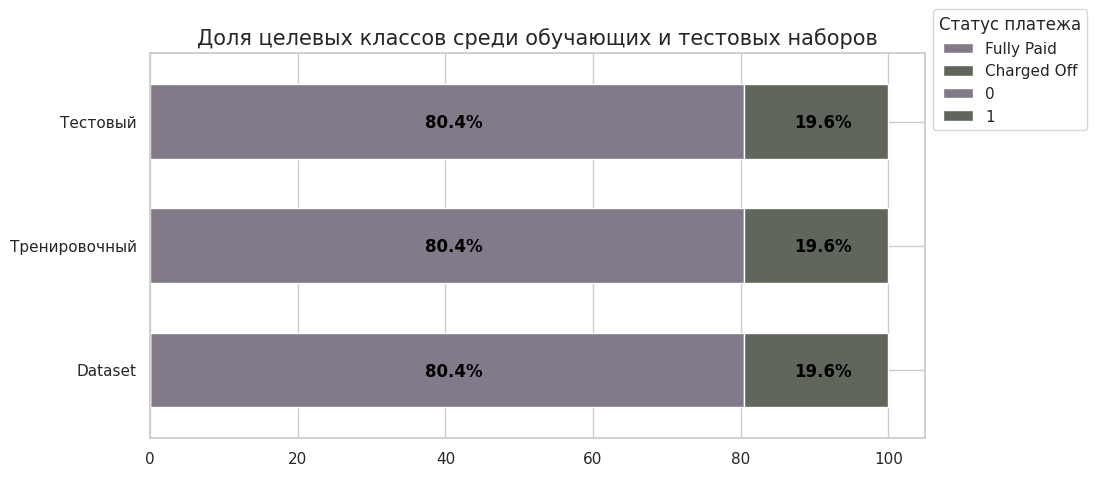

In [ ]:
df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_perc.columns=['Dataset','Тренировочный','Тестовый']
df_perc = df_perc.T

df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)

for idx, val in enumerate([*df_perc.index.values]):
    for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%',
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Статус платежа', loc=(1.01,0.8))
plt.xlabel(' ', fontsize=15)
plt.title('Доля целевых классов среди обучающих и тестовых наборов', fontsize=15)
plt.show()

Таким образом, видим, что дисбаланса между классами в обучающей и тестовой выборке нет